<a href="https://colab.research.google.com/github/IlyaZutler/Project-3-Berlin-Airbnb-Ratings/blob/main/7%20Model%20Selection%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model Selection**

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install openpyxl -q
import openpyxl
import pickle

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# for grid
!pip install geopy -q
from geopy.distance import geodesic

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# CatBoost
!pip install catboost -q
from catboost import CatBoostRegressor, Pool
# XGBoost
import xgboost as xgb
from xgboost import XGBRegressor
# RandomForest
from sklearn.ensemble import RandomForestRegressor
# Linear Regression+l1 Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
# AdaBoost
from sklearn.ensemble import AdaBoostRegressor
# LightGBM
import lightgbm as lgb

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

!pip -qq install category_encoders
from category_encoders import TargetEncoder

# Set display options
%matplotlib inline
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 1000)

In [ ]:
# apartments = pd.read_excel('https://raw.githubusercontent.com/IlyaZutler/Project-3-Berlin-Airbnb-Ratings/main/apartments_5.xlsx', engine='openpyxl')

In [64]:
# import pickle

!wget https://github.com/IlyaZutler/Project-3-Berlin-Airbnb-Ratings/raw/main/apartments5.pkl -q

with open('apartments5.pkl', 'rb') as f:
    apartments = pickle.load(f)

Drop notinformative columns and make Encodin

In [65]:
apartments.drop(columns=['Host Since','First Review', 'Last Review','Reviews', 'Latitude_Bin', 'Longitude_Bin', 'Latitude_Bin2', 'Longitude_Bi2n','Listing ID'], inplace=True)

apartments['Is Superhost'] = apartments['Is Superhost'].replace({'t': 1, 'f': 0}).fillna(0).astype(int)
apartments['Instant Bookable'] = apartments['Instant Bookable'].replace({'t': 1, 'f': 0}).fillna(0).astype(int)
apartments['Is Exact Location'] = apartments['Is Exact Location'].replace({'t': 1, 'f': 0}).fillna(0).astype(int)

apartments['Host Response Time'] = apartments['Host Response Time'].replace(
    {'within an hour':0, 'within a few hours': 1, 'within a day': 2, 'a few days or more': 3 }).fillna(3).astype(int)


# Программа для всех сразу

In [ ]:
# # prompt: преобразовать нечисловые столбфы в категориальные

# # Select non-numeric columns
# non_numeric_columns = apartments.select_dtypes(exclude=['number']).columns

# # Convert non-numeric columns to categorical
# apartments[non_numeric_columns] = apartments[non_numeric_columns].astype('category')


In [78]:
X = apartments.drop(columns=['Price', 'Price Log'])
y = apartments['Price']

# rare categories to Other
col_obj = X.select_dtypes(exclude='number').columns
for col in col_obj:
    value_counts = X[col].value_counts()
    rare_categories = value_counts[value_counts < 10].index
    X[col] = X[col].replace(rare_categories, 'Other')

# Convert all columns in `col_obj` to string type
X[col_obj] = X[col_obj].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=179)

# Определение категориальных и числовых признаков
cat_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = X_train.select_dtypes(include=['number']).columns.tolist()

# Preprocessor для числовых и категориальных данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Заполнение пропусков средним значением для числовых данных
            ('scaler', StandardScaler())
        ]), num_features),

        ('cat_onehot', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Заполнение пропусков для категориальных данных
            ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
        ]), cat_features)
    ])

# Функция для получения имен признаков после One-Hot Encoding
def get_feature_names_onehot(preprocessor, cat_features, num_features):
    # Обучаем препроцессор на тренировочных данных
    preprocessor.fit(X_train)

    # Получаем имена новых категориальных признаков
    ohe_feature_names = preprocessor.named_transformers_['cat_onehot'].named_steps['onehot'].get_feature_names_out(cat_features)

    # Объединяем числовые и категориальные имена признаков
    all_feature_names = np.concatenate([num_features, ohe_feature_names])

    return all_feature_names

# Полный pipeline для One-Hot Encoding
onehot_full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Lasso())
])

# Полный pipeline для Target Encoding (обработка категориальных переменных отдельно)
targetenc_pipeline = Pipeline(steps=[
    ('target_enc', TargetEncoder(min_samples_leaf=10, handle_missing='value', handle_unknown='value'))
])

targetenc_full_pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),  # Заполнение пропусков средним значением для числовых данных
                ('scaler', StandardScaler())
            ]), num_features),

            ('cat_targetenc', targetenc_pipeline, cat_features)
        ])),
    ('model', Lasso())
])

# Список моделей
models = {
    'Lasso': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(silent=True, random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# Функция для обучения модели и сбора метрик
def evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name, feature_names, encoding_method):
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    metrics = {
        'Model': model_name,
        'Encoding Method': encoding_method,
        'Train MSE': mean_squared_error(y_train, y_train_pred),
        'Test MSE': mean_squared_error(y_test, y_test_pred),
        'Train R2': r2_score(y_train, y_train_pred),
        'Test R2': r2_score(y_test, y_test_pred)
    }

    # Извлечение важности признаков
    if model_name == 'Lasso':
        feature_importances = np.abs(pipeline.named_steps['model'].coef_)
    else:
        feature_importances = pipeline.named_steps['model'].feature_importances_

    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    return metrics, feature_importance_df

# Таблицы для метрик и важностей признаков
metrics_table = pd.DataFrame()
feature_importance_onehot = pd.DataFrame()
feature_importance_targetenc = pd.DataFrame()

# Оценка моделей с One-Hot Encoding
for model_name, model in models.items():
    onehot_full_pipeline.set_params(model=model)
    all_feature_names = get_feature_names_onehot(preprocessor, cat_features, num_features)

    metrics, feature_importances = evaluate_model(onehot_full_pipeline, X_train, X_test, y_train, y_test, model_name, all_feature_names, 'One-Hot Encoding')
    metrics_table = pd.concat([metrics_table, pd.DataFrame([metrics])], ignore_index=True)
    feature_importance_onehot = pd.concat([feature_importance_onehot, feature_importances.rename(columns={'Importance': model_name +'OH'})], axis=1)

# Оценка моделей с Target Encoding
for model_name, model in models.items():
    targetenc_full_pipeline.set_params(model=model)
    all_feature_names = np.concatenate([num_features, cat_features])

    metrics, feature_importances = evaluate_model(targetenc_full_pipeline, X_train, X_test, y_train, y_test, model_name, all_feature_names, 'Target Encoding')
    metrics_table = pd.concat([metrics_table, pd.DataFrame([metrics])], ignore_index=True)
    feature_importance_targetenc = pd.concat([feature_importance_targetenc, feature_importances.rename(columns={'Importance': model_name +'TE'})], axis=1)

# Сохранение метрик и важностей признаков в CSV
metrics_table.to_csv('model_metrics.csv', index=False)
feature_importance_onehot.to_csv('feature_importance_onehot.csv', index=False)
feature_importance_targetenc.to_csv('feature_importance_targetenc.csv', index=False)

# Вывод метрик и важностей
print(metrics_table)
print("Feature Importance with One-Hot Encoding:")
print(feature_importance_onehot)
print("Feature Importance with Target Encoding:")
print(feature_importance_targetenc)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4332
[LightGBM] [Info] Number of data points in the train set: 17067, number of used features: 689
[LightGBM] [Info] Start training from score 59.431242
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3766
[LightGBM] [Info] Number of data points in the train set: 17067, number of used features: 37
[LightGBM] [Info] Start training from score 59.431242
           Model   Encoding Method   Train MSE    Test MSE  Train R2   Test R2
0          Lasso  One-Hot Encoding  871.957390  918.951960  0.484580  0.483271
1  Random Forest  One-Hot E

In [79]:
metrics_table

,Model,Encoding Method,Train MSE,Test MSE,Train R2,Test R2
0,Lasso,One-Hot Encoding,871.957390,918.951960,0.484580,0.483271
1,Random Forest,One-Hot Encoding,103.022987,779.884267,0.939102,0.561469
2,CatBoost,One-Hot Encoding,450.767559,708.462029,0.733548,0.601630
3,LightGBM,One-Hot Encoding,479.443476,713.722285,0.716598,0.598672
4,XGBoost,One-Hot Encoding,364.235382,745.953305,0.784698,0.580549
5,Lasso,Target Encoding,785.886984,858.596348,0.535457,0.517209
6,Random Forest,Target Encoding,99.084997,753.494087,0.941430,0.576308
7,CatBoost,Target Encoding,360.302146,709.450026,0.787023,0.601074
8,LightGBM,Target Encoding,442.315090,717.462293,0.738544,0.596569
9,XGBoost,Target Encoding,235.544445,769.706425,0.860768,0.567192


In [80]:
feature_importance_targetenc

,Feature,LassoTE,Feature,Random ForestTE,Feature,CatBoostTE,Feature,LightGBMTE,Feature,XGBoostTE
0,Accomodates,8.567564,Accomodates,0.250354,Room Type,11.874937,Bin-Bin,215,Room Type,0.172944
1,Bedrooms,7.359142,Room Type,0.084707,Accomodates,10.473251,Bin2-Bin2,198,Bathrooms,0.139993
2,Guests Included,3.883253,Bedrooms,0.069192,Bin2-Bin2,7.656064,Host Since Years,184,Accomodates,0.135457
3,Bathrooms,2.476378,Bin2-Bin2,0.066780,Bedrooms,7.361360,Postal Code,165,Bedrooms,0.135251
4,Distance_from_center,1.528157,Bin-Bin,0.039330,Property Type,6.867276,Longitude,157,Property Type,0.052366
5,Cleanliness Rating,1.413081,Property Type,0.037153,Bin-Bin,4.704026,Last Review Years,154,Bin2-Bin2,0.032860
6,Last Review Years,1.103095,Bathrooms,0.036258,Guests Included,4.306243,Accomodates,152,Guests Included,0.027812
7,Host Response Time,1.006163,Postal Code,0.035829,Bathrooms,4.018482,Distance_from_center,141,Postal Code,0.023883
8,Reviews Log,0.879953,Host Since Years,0.035507,Host Since Years,3.458810,Property Type,139,Bin-Bin,0.022096
9,Polarity_mean,0.784407,Longitude,0.033366,Postal Code,3.401513,First Review Years,120,neighbourhood,0.013763


In [81]:
feature_importance_onehot2 = feature_importance_onehot.copy()
for i in range(feature_importance_onehot.shape[0]):
    for j in apartments.columns:
        if j in feature_importance_onehot.iloc[i,0]:
            feature_importance_onehot.iloc[i,0] = j
        if j in feature_importance_onehot.iloc[i,2]:
            feature_importance_onehot.iloc[i,2] = j
        if j in feature_importance_onehot.iloc[i,4]:
            feature_importance_onehot.iloc[i,4] = j
        if j in feature_importance_onehot.iloc[i,6]:
            feature_importance_onehot.iloc[i,6] = j
        if j in feature_importance_onehot.iloc[i,8]:
            feature_importance_onehot.iloc[i,8] = j

In [86]:
lasso_imp = feature_importance_onehot.iloc[:,1].groupby(feature_importance_onehot.iloc[:,0]).sum().sort_values(ascending=False)
forest_imp = feature_importance_onehot.iloc[:,3].groupby(feature_importance_onehot.iloc[:,2]).sum().sort_values(ascending=False)
CatB_imp = feature_importance_onehot.iloc[:,5].groupby(feature_importance_onehot.iloc[:,4]).sum().sort_values(ascending=False)
lGBM_imp = feature_importance_onehot.iloc[:,7].groupby(feature_importance_onehot.iloc[:,6]).sum().sort_values(ascending=False)
XGB_imp = feature_importance_onehot.iloc[:,9].groupby(feature_importance_onehot.iloc[:,8]).sum().sort_values(ascending=False)

lasso_impTE = feature_importance_targetenc.iloc[:,1].groupby(feature_importance_targetenc.iloc[:,0]).sum().sort_values(ascending=False)
forest_impTE = feature_importance_targetenc.iloc[:,3].groupby(feature_importance_targetenc.iloc[:,2]).sum().sort_values(ascending=False)
CatB_impTE = feature_importance_targetenc.iloc[:,5].groupby(feature_importance_targetenc.iloc[:,4]).sum().sort_values(ascending=False)
lGBM_impTE = feature_importance_targetenc.iloc[:,7].groupby(feature_importance_targetenc.iloc[:,6]).sum().sort_values(ascending=False)
XGB_impTE = feature_importance_targetenc.iloc[:,9].groupby(feature_importance_targetenc.iloc[:,8]).sum().sort_values(ascending=False)

merged_imp = pd.merge(lasso_imp, forest_imp, left_on='Feature', right_on='Feature', how='left')
merged_imp = pd.merge(merged_imp, CatB_imp, left_on='Feature', right_on='Feature', how='left')
merged_imp = pd.merge(merged_imp, lGBM_imp, left_on='Feature', right_on='Feature', how='left')
merged_imp = pd.merge(merged_imp, XGB_imp, left_on='Feature', right_on='Feature', how='left')

merged_imp = pd.merge(merged_imp, lasso_impTE, left_on='Feature', right_on='Feature', how='left')
merged_imp = pd.merge(merged_imp, forest_impTE, left_on='Feature', right_on='Feature', how='left')
merged_imp = pd.merge(merged_imp, CatB_impTE, left_on='Feature', right_on='Feature', how='left')
merged_imp = pd.merge(merged_imp, lGBM_impTE, left_on='Feature', right_on='Feature', how='left')
merged_imp = pd.merge(merged_imp, XGB_impTE, left_on='Feature', right_on='Feature', how='left')

merged_imp['Lasso RankOH'] = merged_imp['LassoOH'].rank(ascending=False)
merged_imp['Random Forest RankOH'] = merged_imp['Random ForestOH'].rank(ascending=False)
merged_imp['CatBoost RankOH'] = merged_imp['CatBoostOH'].rank(ascending=False)
merged_imp['LightGBM RankOH'] = merged_imp['LightGBMOH'].rank(ascending=False)
merged_imp['XGBoost RankOH'] = merged_imp['XGBoostOH'].rank(ascending=False)

merged_imp['Lasso RankTE'] = merged_imp['LassoTE'].rank(ascending=False)
merged_imp['Random Forest RankTE'] = merged_imp['Random ForestTE'].rank(ascending=False)
merged_imp['CatBoost RankTE'] = merged_imp['CatBoostTE'].rank(ascending=False)
merged_imp['LightGBM RankTE'] = merged_imp['LightGBMTE'].rank(ascending=False)
merged_imp['XGBoost RankTE'] = merged_imp['XGBoostTE'].rank(ascending=False)

merged_imp

,LassoOH,Random ForestOH,CatBoostOH,LightGBMOH,XGBoostOH,LassoTE,Random ForestTE,CatBoostTE,LightGBMTE,XGBoostTE,Lasso RankOH,Random Forest RankOH,CatBoost RankOH,LightGBM RankOH,XGBoost RankOH,Lasso RankTE,Random Forest RankTE,CatBoost RankTE,LightGBM RankTE,XGBoost RankTE
Feature,,,,,,,,,,,,,,,,,,,,
Room Type,17.763347,0.086095,15.723867,72,0.040596,0.510543,0.084707,11.874937,76,0.172944,1.0,2.0,1.0,18.5,7.0,14.0,2.0,1.0,17.0,1.0
Accomodates,9.748674,0.250886,12.241314,146,0.029632,8.567564,0.250354,10.473251,152,0.135457,2.0,1.0,2.0,7.0,9.0,1.0,1.0,2.0,7.0,3.0
Bedrooms,7.640069,0.067990,7.689859,82,0.040998,7.359142,0.069192,7.361360,93,0.135251,3.0,3.0,4.0,16.0,6.0,2.0,3.0,4.0,15.0,4.0
neighbourhood,4.504089,0.027733,2.790489,97,0.114732,0.000000,0.012742,1.582705,64,0.013763,4.0,12.0,8.0,13.0,4.0,29.0,21.0,23.0,20.0,10.0
Guests Included,4.292955,0.020014,5.153972,100,0.007940,3.883253,0.017985,4.306243,97,0.027812,5.0,15.0,6.0,11.0,11.0,3.0,16.0,7.0,13.0,7.0
Distance_from_center,3.470432,0.037374,5.149459,203,0.005676,1.528157,0.029489,2.737601,141,0.010111,6.0,8.0,7.0,1.0,12.0,5.0,12.0,12.0,8.0,18.0
Bathrooms,3.032975,0.039414,5.564266,45,0.035529,2.476378,0.036258,4.018482,44,0.139993,7.0,7.0,5.0,28.0,8.0,4.0,7.0,8.0,27.0,2.0
Host Response Time,2.677327,0.009990,2.355606,49,0.001163,1.006163,0.008734,1.771772,41,0.010123,8.0,23.0,14.0,26.0,31.0,8.0,25.0,20.0,28.0,17.0
Cleanliness Rating,2.163179,0.004601,1.163108,48,0.002636,1.413081,0.005371,0.987639,51,0.013631,9.0,29.0,24.0,27.0,17.0,6.0,29.0,28.0,24.0,11.0


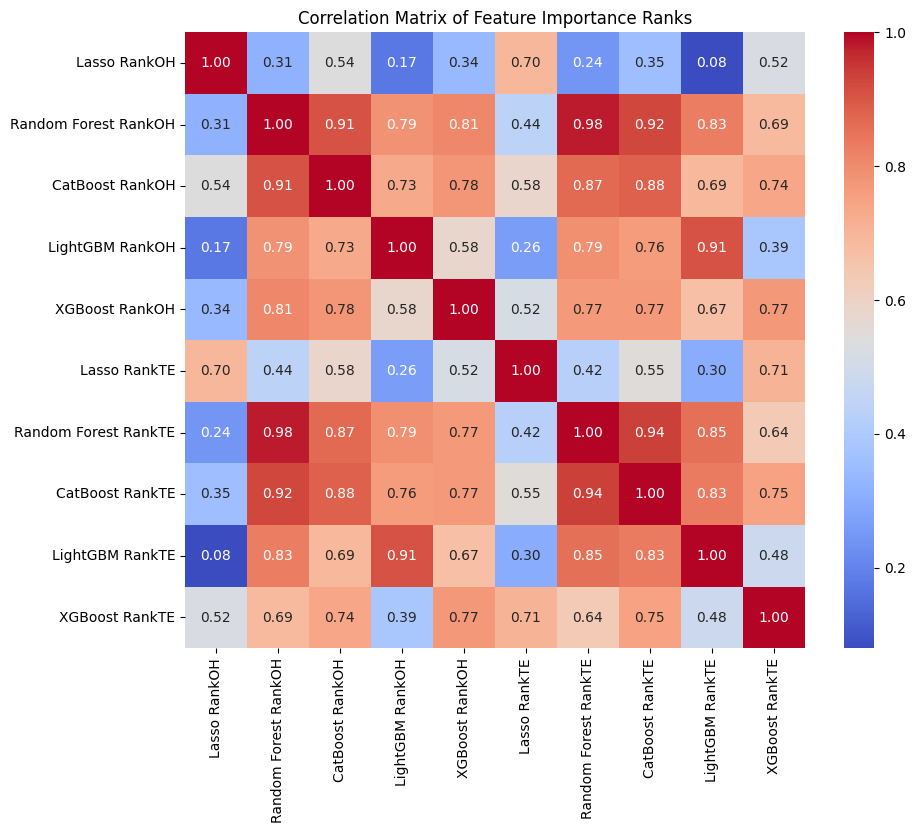

In [89]:
# Выберите столбцы для корреляции
rank_columns = ['Lasso RankOH', 'Random Forest RankOH', 'CatBoost RankOH',
       'LightGBM RankOH', 'XGBoost RankOH', 'Lasso RankTE',
       'Random Forest RankTE', 'CatBoost RankTE', 'LightGBM RankTE',
       'XGBoost RankTE']

# Вычислите корреляционную матрицу
correlation_matrix = merged_imp[rank_columns].corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Feature Importance Ranks')
plt.show()


In [90]:
# apartments.to_excel('apartments_5.xlsx', index=False)

# import pickle

with open('apartments6.pkl', 'wb') as f:
    pickle.dump(apartments, f)


in English

In [ ]:
X = apartments.drop(columns=['Price', 'Price Log'])
y = apartments['Price']

# rare categories to Other
col_obj = X.select_dtypes(exclude='number').columns
for col in col_obj:
    value_counts = X[col].value_counts()
    rare_categories = value_counts[value_counts < 10].index
    X[col] = X[col].replace(rare_categories, 'Other')

# Convert all columns in `col_obj` to string type
X[col_obj] = X[col_obj].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=179)

# Identify categorical and numerical features
cat_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = X_train.select_dtypes(include=['number']).columns.tolist()

# Preprocessor for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        # Pipeline for numerical features: imputing missing values with mean and standard scaling
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), num_features),

        # Pipeline for categorical features: imputing missing values with 'missing' and One-Hot Encoding
        ('cat_onehot', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
        ]), cat_features)
    ])

# Function to get feature names after One-Hot Encoding
def get_feature_names_onehot(preprocessor, cat_features, num_features):
    # Fit the preprocessor on the training data
    preprocessor.fit(X_train)

    # Get the names of the new categorical features
    ohe_feature_names = preprocessor.named_transformers_['cat_onehot'].named_steps['onehot'].get_feature_names_out(cat_features)

    # Combine numerical and categorical feature names
    all_feature_names = np.concatenate([num_features, ohe_feature_names])

    return all_feature_names

# Full pipeline for One-Hot Encoding
onehot_full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Lasso())
])

# Pipeline for Target Encoding (categorical variables are processed separately)
targetenc_pipeline = Pipeline(steps=[
    ('target_enc', TargetEncoder(min_samples_leaf=10, handle_missing='value', handle_unknown='value'))
])

# Full pipeline for Target Encoding
targetenc_full_pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            # Pipeline for numerical features: imputing missing values with mean and standard scaling
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), num_features),

            # Pipeline for categorical features: Target Encoding
            ('cat_targetenc', targetenc_pipeline, cat_features)
        ])),
    ('model', Lasso())
])

# List of models to be evaluated
models = {
    'Lasso': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(silent=True, random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# Function to train the model and collect metrics
def evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name, feature_names, encoding_method):
    # Fit the model pipeline
    pipeline.fit(X_train, y_train)

    # Predict on the train and test sets
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # Calculate and store metrics
    metrics = {
        'Model': model_name,
        'Encoding Method': encoding_method,
        'Train MSE': mean_squared_error(y_train, y_train_pred),
        'Test MSE': mean_squared_error(y_test, y_test_pred),
        'Train R2': r2_score(y_train, y_train_pred),
        'Test R2': r2_score(y_test, y_test_pred)
    }

    # Extract feature importances
    if model_name == 'Lasso':
        feature_importances = np.abs(pipeline.named_steps['model'].coef_)
    else:
        feature_importances = pipeline.named_steps['model'].feature_importances_

    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    return metrics, feature_importance_df

# Tables to store metrics and feature importances
metrics_table = pd.DataFrame()
feature_importance_onehot = pd.DataFrame()
feature_importance_targetenc = pd.DataFrame()

# Evaluate models with One-Hot Encoding
for model_name, model in models.items():
    onehot_full_pipeline.set_params(model=model)
    all_feature_names = get_feature_names_onehot(preprocessor, cat_features, num_features)

    metrics, feature_importances = evaluate_model(onehot_full_pipeline, X_train, X_test, y_train, y_test, model_name, all_feature_names, 'One-Hot Encoding')
    metrics_table = pd.concat([metrics_table, pd.DataFrame([metrics])], ignore_index=True)
    feature_importance_onehot = pd.concat([feature_importance_onehot, feature_importances.rename(columns={'Importance': model_name})], axis=1)

# Evaluate models with Target Encoding
for model_name, model in models.items():
    targetenc_full_pipeline.set_params(model=model)
    all_feature_names = np.concatenate([num_features, cat_features])

    metrics, feature_importances = evaluate_model(targetenc_full_pipeline, X_train, X_test, y_train, y_test, model_name, all_feature_names, 'Target Encoding')
    metrics_table = pd.concat([metrics_table, pd.DataFrame([metrics])], ignore_index=True)
    feature_importance_targetenc = pd.concat([feature_importance_targetenc, feature_importances.rename(columns={'Importance': model_name})], axis=1)

# Save metrics and feature importances to CSV files
metrics_table.to_csv('model_metrics.csv', index=False)
feature_importance_onehot.to_csv('feature_importance_onehot.csv', index=False)
feature_importance_targetenc.to_csv('feature_importance_targetenc.csv', index=False)

# Display metrics and feature importances
print(metrics_table)
print("Feature Importance with One-Hot Encoding:")
print(feature_importance_onehot)
print("Feature Importance with Target Encoding:")
print(feature_importance_targetenc)
